In [1]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
import eia
import seaborn as sns
import statistics
import os
import re
sns.set()

from matplotlib import rc
sns.set()
sns.color_palette("bright")
sns.set_color_codes(palette='bright')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%matplotlib notebook

In [2]:
import math 
def partition_js(data):
    data = sorted(data)

    best_split_indices = [len(data)]
    best_split_score = score(best_split_indices, data)
    #print(" ")

    for split_index in range(0, len(data) - 1):
        split_indices = [split_index, len(data)]
        s = score(split_indices, data)
        # print("s overall", s)
        if s > best_split_score:
            best_split_score = s
            best_split_indices = split_indices
        #print(" ")

    for first_split in range(0, len(data) - 1):
        for second_split in range(first_split + 1, len(data) - 1):
            split_indices = [first_split, second_split, len(data)]
            # print(split_indices)
            s = score(split_indices, data)
            if s > best_split_score:
                best_split_score = s
                best_split_indices = split_indices
            #print(" ")
        #print(" ")

    return len(best_split_indices), best_split_indices, best_split_score

def score(splits, data: list[float]) -> float:
    score = 0
    split_start = 0
    for i in splits:
        # print("i", i)
        group = data[split_start: i + 1]
        #print("group", group)
        split_start = i + 1
        # print("variance: ", statistics.variance(group))
        if len(group) == 1:
            score = score**3
        else:
            score += statistics.variance(group)
        # instead of variance median absolute distance to median
        # https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    #print("score", score)
    return -np.exp(len(splits) + 1) * score


res1, _, _ = partition_js([0,0,0,0,1,1,2,2])
res2, _, _ = partition_js([0,0,0,0,1,1])
res3, _, _ = partition_js([0,0,0,0])
res4, _, _ = partition_js([0,0,0,0,1])

if res1 != 3 or res2 != 2 or res3 != 1 or res4 != 2:
    print(res1,res2,res3, res4)
    print("WARNING")

AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_137_x65y_102_csvIntTrace.csv


<IPython.core.display.Javascript object>


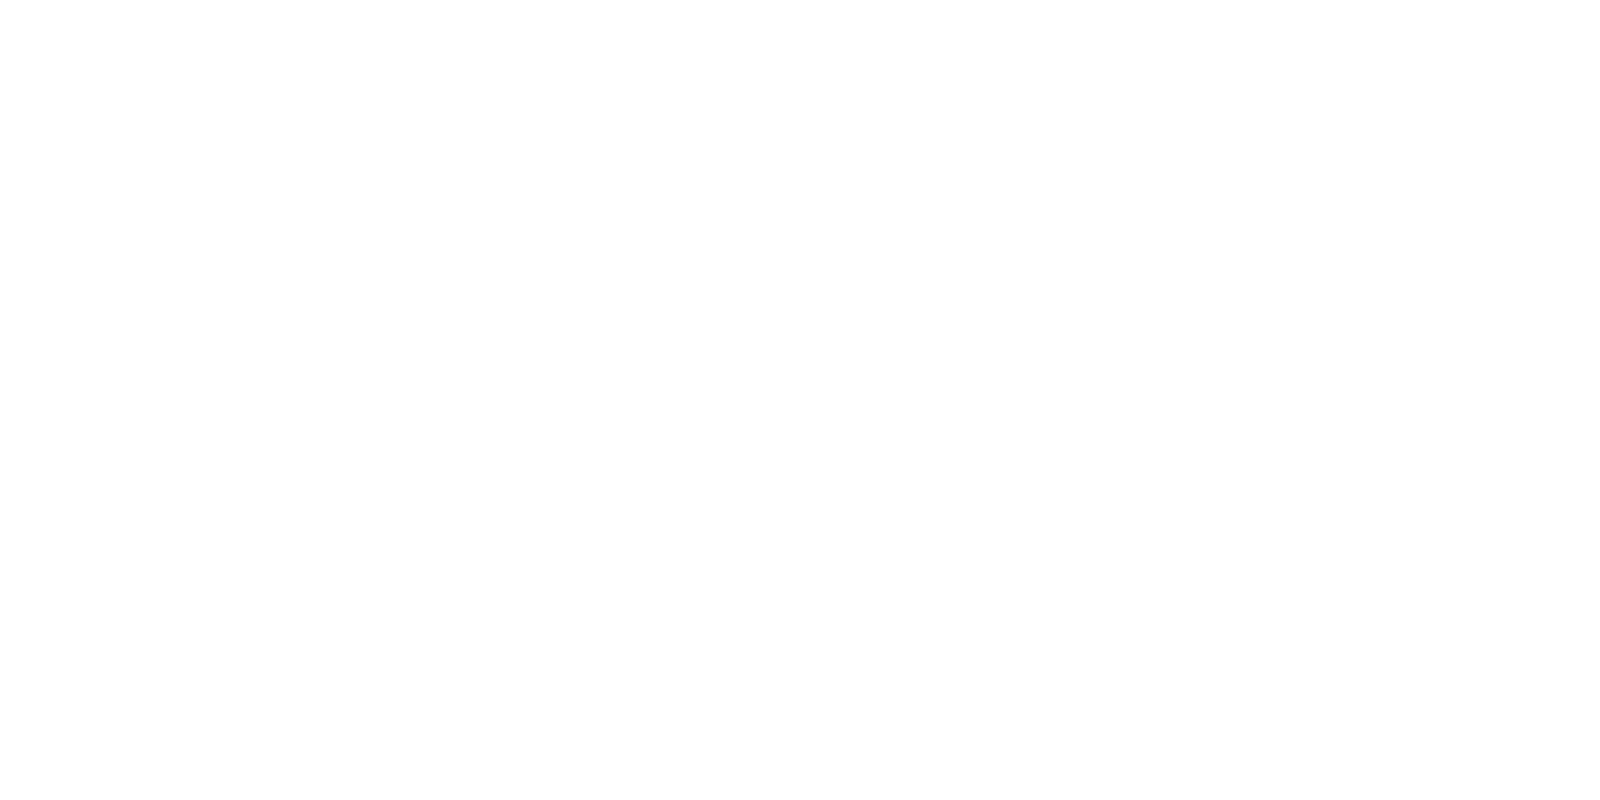

[60.0, 61.0, 62.0, 62.5, 63.0, 63.5, 65.0, 116.0, 127.5, 170.0, 172.5, 324.0, 365.5, 412.5, 447.5, 449.5, 450.0, 454.5, 458.0, 458.5, 461.0, 470.0, 478.5, 479.5]


In [3]:
#df_temp = pd.read_csv("Data/AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_16_x89y_102_csvIntTrace.csv")

# nonsingular: 103
# singular: 78, 112

for filename in sorted(os.listdir("data/")):
    if not filename.endswith("csvIntTrace.csv"):
        continue 
    
    if int(re.search(r"Particle_(\d{1,3})_", filename).group(1)) == 137:
        df_temp = pd.read_csv("Data/" + filename)
        print(filename)



df = pd.DataFrame()
df["x"] = df_temp.x[::3]
df["y"] = df_temp.y[::3]

points = df.y.values

# RUPTURES PACKAGE
# Changepoint detection with the Pelt search method
model = "rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=3)
fig,_ = rpt.display(points, result, figsize=(8, 4))


# pad result with the start value of df.x
result_array = np.insert(result, 0, np.min(df.x), axis=0)

count_levels = np.zeros(np.size(result_array) - 1)
time_count = np.zeros(np.size(result_array) - 1)
# TODO: Check if lowest count level is at bg
# TODO: Maybe put a weight on the count states? I.e., longer more important

for i in range(0, np.size(result_array) - 1):
    i_start = result_array[i]
    i_end = result_array[i + 1] - 1
    count_levels[i] = np.median(df.y[i_start:i_end])        
    time_count[i] = i_end - i_start
    plt.hlines(y=np.median(df.y[i_start:i_end]), xmin=i_start, xmax=i_end, linewidth=2, color='r')

plt.title('Change Point Detection: Pelt Search Method')
plt.xlabel("Time [a.u.]")
plt.ylabel("Counts [a.u.]")
plt.tight_layout()
time_count = time_count * np.max(df.x) / np.max(result_array)
print(sorted(count_levels))
partition_js(count_levels.tolist())
fig.savefig("data/changepoint_ruptures_137.pdf")

In [4]:
time_below_threshold = 0
for (time, level) in zip(time_count, count_levels):
    if level < 100:
        time_below_threshold += time
time_below_threshold

78.8211

In [5]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os
import re
import math
sns.set()
sns.set_palette("bright")
palette = sns.color_palette("bright")
%matplotlib notebook
#matplotlib.use("Qt5Agg")

# These are without the iterations for singular arrays
"""
def partition_js(data):
    data = sorted(data)

    best_split_indices = [len(data)]
    best_split_score = score(best_split_indices, data)

    for split_index in range(1, len(data) - 2):
        split_indices = [split_index, len(data)]
        s = score(split_indices, data)
        # print("s overall", s)
        if s > best_split_score:
            best_split_score = s
            best_split_indices = split_indices

    for first_split in range(1, len(data) - 3):
        for second_split in range(first_split + 2, len(data) - 2):
            split_indices = [first_split, second_split, len(data)]
            # print(split_indices)
            s = score(split_indices, data)
            if s > best_split_score:
                best_split_score = s
                best_split_indices = split_indices

    return len(best_split_indices), best_split_indices, best_split_score


def score(splits, data: list[float]) -> float:
    score = 0
    split_start = 0
    for i in splits:
        # print("i", i)
        group = data[split_start: i + 1]
        # print("group", group)
        split_start = i + 1
        # print("variance: ", statistics.variance(group))
        score += statistics.variance(group)
        # instead of variance median absolute distance to median
        # https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
        # print("score", score)
    return -(len(splits)**(2.8) + 1) * score
"""

def partition_js(data):
    data = sorted(data)

    best_split_indices = [len(data)]
    best_split_score = score(best_split_indices, data)
    #print(" ")

    for split_index in range(0, len(data) - 1):
        split_indices = [split_index, len(data)]
        s = score(split_indices, data)
        # print("s overall", s)
        if s > best_split_score:
            best_split_score = s
            best_split_indices = split_indices
        #print(" ")

    for first_split in range(0, len(data) - 1):
        for second_split in range(first_split + 1, len(data) - 1):
            split_indices = [first_split, second_split, len(data)]
            # print(split_indices)
            s = score(split_indices, data)
            if s > best_split_score:
                best_split_score = s
                best_split_indices = split_indices
            #print(" ")
        #print(" ")

    return len(best_split_indices), best_split_indices, best_split_score

def score(splits, data: list[float]) -> float:
    score = 0
    split_start = 0
    for i in splits:
        # print("i", i)
        group = data[split_start: i + 1]
        #print("group", group)
        split_start = i + 1
        # print("variance: ", statistics.variance(group))
        if len(group) == 1:
            score += 0
        else:
            score += statistics.variance(group)
        # instead of variance median absolute distance to median
        # https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    #print("score", score)
    return -(len(splits) + 1) * score

def changepoint_analysis(filename: str):
    # ATTENTION: USE EVERY THIRD POINTS
    df = pd.DataFrame()
    df["x"] = df_temp.x[::3]
    df["y"] = df_temp.y[::3]

    points = df.y.values

    # RUPTURES PACKAGE
    # Changepoint detection with the Pelt search method
    model = "rbf"
    algo = rpt.Pelt(model=model).fit(points)
    result = algo.predict(pen=1)
    # print("result")

    # pad result with the start value of df.x
    result_array = np.insert(result, 0, np.min(df.x), axis=0)

    count_levels = np.zeros(np.size(result_array) - 1)
    time_count = np.zeros(np.size(result_array) - 1)
    # df_res = pd.DataFrame()
    # TODO: Check if lowest count level is at bg
    # TODO: Maybe put a weight on the count states? I.e., longer more important

    for i in range(0, np.size(result_array) - 1):
        i_start = result_array[i]
        i_end = result_array[i + 1] - 1
        count_levels[i] = np.median(df.y[i_start:i_end])
        time_count[i] = i_end - i_start
        # length_of_interval.append(i_end - i_start)
        # df_res.at[i, 'median_levels'] = np.median(df.y[i_start:i_end])
        # df_res.at[i, 'i_start'] = i_start
        # df_res.at[i, 'i_end'] = i_end
        # df_res.at[i, 't_start'] = df.x[i_start]
        # df_res.at[i, 't_end'] = df.x[i_end]
        # df_res.at[i, 'time_diff'] = df.x[i_end] - df.x[i_start]
    # print("iterated")
    # print(df_res.median_levels)
    time_count = time_count * np.max(df.x) / np.max(result_array)

    time_below_threshold_75 = 0
    time_below_threshold_100 = 0
    time_below_threshold_125 = 0
    time_above_threshold = 0
    
    for (time, level) in zip(time_count, count_levels):
        if level < 50:
            time_below_threshold_75 += time
        
        if level < 100:
            time_below_threshold_100 += time
            
        if level < 200:
            time_below_threshold_125 += time
        if level > 250:
            time_above_threshold += time
            
    df_histogram.at[particle_no, "time_below_threshold_75"] = time_below_threshold_75
    df_histogram.at[particle_no, "time_below_threshold_100"] = time_below_threshold_100
    df_histogram.at[particle_no, "time_below_threshold_125"] = time_below_threshold_125
    df_histogram.at[particle_no, "time_above_threshold"] = time_above_threshold

    if len(count_levels) == 1:
        array.append((particle_no, 1))
        if (df_g2[df_g2["particle_no"] == particle_no].state == "singular").values[0]:
            array_correct.append(False)
            array_correct_no.append((particle_no, 1))

    no_states, _, _ = partition_js(count_levels.tolist())
    array.append((particle_no, no_states))
    # print("partition completed")

    if (df_g2[df_g2["particle_no"] == particle_no].state == "singular").values[0]:
        if no_states == 2:
            array_correct.append(True)
            array_correct_no.append((particle_no, no_states))
        else:
            array_correct.append(False)
            array_wrong_no.append((particle_no, no_states))
    elif no_states == 2:
        array_wrong_no.append((particle_no, no_states))

def histogram_integral_max(df: pd.DataFrame(), bright_dark_cutoff: int, filename: str):
    """
    Calculate the integral based on a count threshold for the dark and bright states. Find the maximum within these
    regions.
    """
    # create the histogram
    histogram = np.histogram(df.y.values, int(max(df.y.values / 2)), [0, int(max(df.y.values))])
    histogram_x = histogram[0]
    histogram_y = 0.5 * (histogram[1][:-1] + histogram[1][1:])

    # check if counts includes the bright_dark_cutoff value
    bright_dark_cutoff_idx = (
        np.abs(histogram_y - bright_dark_cutoff)).argmin()  # find the idx closest to bright_dark_cutoff

    dark_sum = np.sum(histogram_x[:bright_dark_cutoff_idx])
    bright_sum = np.sum(histogram_x[bright_dark_cutoff_idx:])

    dark_max = np.max(histogram_x[:bright_dark_cutoff_idx])
    bright_max = np.max(histogram_x[bright_dark_cutoff_idx:])

    plt.figure()
    plt.plot(histogram_x[:bright_dark_cutoff_idx], histogram_y[:bright_dark_cutoff_idx])
    plt.plot(histogram_x[bright_dark_cutoff_idx:], histogram_y[bright_dark_cutoff_idx:])
    plt.xlabel('occurrence')
    plt.ylabel('counts / %i ms' % (0.1 * 1e3))  # TODO: Careful! This bin value is fixed
    plt.savefig("Data/Histogram/" + filename[:-4] + "_Histogram.pdf")

    # add values to global (!) df
    df_histogram.at[particle_no, "dark_sum"] = dark_sum
    df_histogram.at[particle_no, "bright_sum"] = bright_sum
    df_histogram.at[particle_no, "dark_max"] = dark_max
    df_histogram.at[particle_no, "bright_max"] = bright_max

    return dark_sum, bright_sum, dark_max, bright_max

if __name__ == "__main__":
    df_g2 = pd.read_csv("Data/state_files.csv")
    df_g2['particle_no'] = df_g2['name'].apply(
        lambda f: int(re.search(r"Particle_(\d{1,3})_", f).group(1)))
    lst_singular = df_g2[df_g2.state == "singular"].particle_no.tolist()
    lst_non_singular = df_g2[df_g2.state == "non_singular"].particle_no.tolist()



    count = 0
    array = []
    array_correct = []
    array_correct_no = [] #contains tuple of files identified correctly
    array_wrong_no = []
    df_histogram = pd.DataFrame()
    for filename in sorted(os.listdir("data/")):
        if not filename.endswith("csvIntTrace.csv"):
            continue

        print(filename)

        particle_no = int(re.search(r"Particle_(\d{1,3})_", filename).group(1))
        print("count: ", count)
        df_temp = pd.read_csv("data/" + filename)

        # determine the g2 value at zero delay
        g2_tau_zero = df_g2[df_g2["particle_no"] == particle_no]["g2_tau_zero"].values[0]
        # add g2 at zero to df
        df_histogram.at[particle_no, "g2_tau_zero"] = g2_tau_zero

        changepoint_analysis(filename);

        #histogram_integral_max(df=df_temp, bright_dark_cutoff=100, filename=filename)

        count += 1

    """
    # Create Histogram Plot
    df_temp = df_histogram
    df_temp.dropna(inplace=True)
    df_temp["sum_ratio"] = df_temp["bright_sum"] / df_temp["dark_sum"]
    df_temp["max_ratio"] = df_temp["bright_max"] / df_temp["dark_max"]

    df_sum = df_temp[df_temp["sum_ratio"] < 100] #outlier rejection

    fig = plt.figure()
    sns.scatterplot(data=df_sum, x="g2_tau_zero", y="sum_ratio", label="all")
    sns.scatterplot(data=df_sum[df_sum["sum_ratio"] < 7], x="g2_tau_zero", y="sum_ratio", label="sum_ratio < 7")
    fig.savefig("Data/g2_vs_sumRatio.pdf")

    fig = plt.figure()
    sns.scatterplot(data=df_temp, x="g2_tau_zero", y="max_ratio", label="all")
    sns.scatterplot(data=df_sum[df_sum["max_ratio"] < 2], x="g2_tau_zero", y="max_ratio", label="max_ratio < 2")
    fig.savefig("Data/g2_vs_maxRatio.pdf")
    """


AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_0_x91y_100_csvIntTrace.csv
count:  0
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_100_x72y_101_csvIntTrace.csv
count:  1
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_101_x72y_97_csvIntTrace.csv
count:  2
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_102_x72y_86_csvIntTrace.csv
count:  3
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_103_x72y_79_csvIntTrace.csv
count:  4
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_104_x72y_78_csvIntTrace.csv
count:  5
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_105_x71y_101_csvIntTrace.csv
count:  6
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range

AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_157_x65y_80_csvIntTrace.csv
count:  63
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_158_x66y_79_csvIntTrace.csv
count:  64
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_159_x68y_99_csvIntTrace.csv
count:  65
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_15_x89y_85_csvIntTrace.csv
count:  66
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_160_x67y_89_csvIntTrace.csv
count:  67
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_161_x73y_108_csvIntTrace.csv
count:  68
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_162_x70y_107_csvIntTrace.csv
count:  69
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z12

AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_60_x80y_104_csvIntTrace.csv
count:  126
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_61_x80y_78_csvIntTrace.csv
count:  127
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_62_x80y_106_csvIntTrace.csv
count:  128
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_63_x80y_89_csvIntTrace.csv
count:  129
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_64_x80y_87_csvIntTrace.csv
count:  130
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_65_x80y_83_csvIntTrace.csv
count:  131
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150_Particle_66_x79y_95_csvIntTrace.csv
count:  132
AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z1

In [6]:
df = df_histogram.dropna()
df["percent_below_threshold_100"] = df["time_below_threshold_100"].copy() / 300

/var/folders/ch/lpt_fc3n7dg2t4v8n0kqp3480000gn/T/ipykernel_25107/1470930122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["percent_below_threshold_100"] = df["time_below_threshold_100"].copy() / 300


<IPython.core.display.Javascript object>


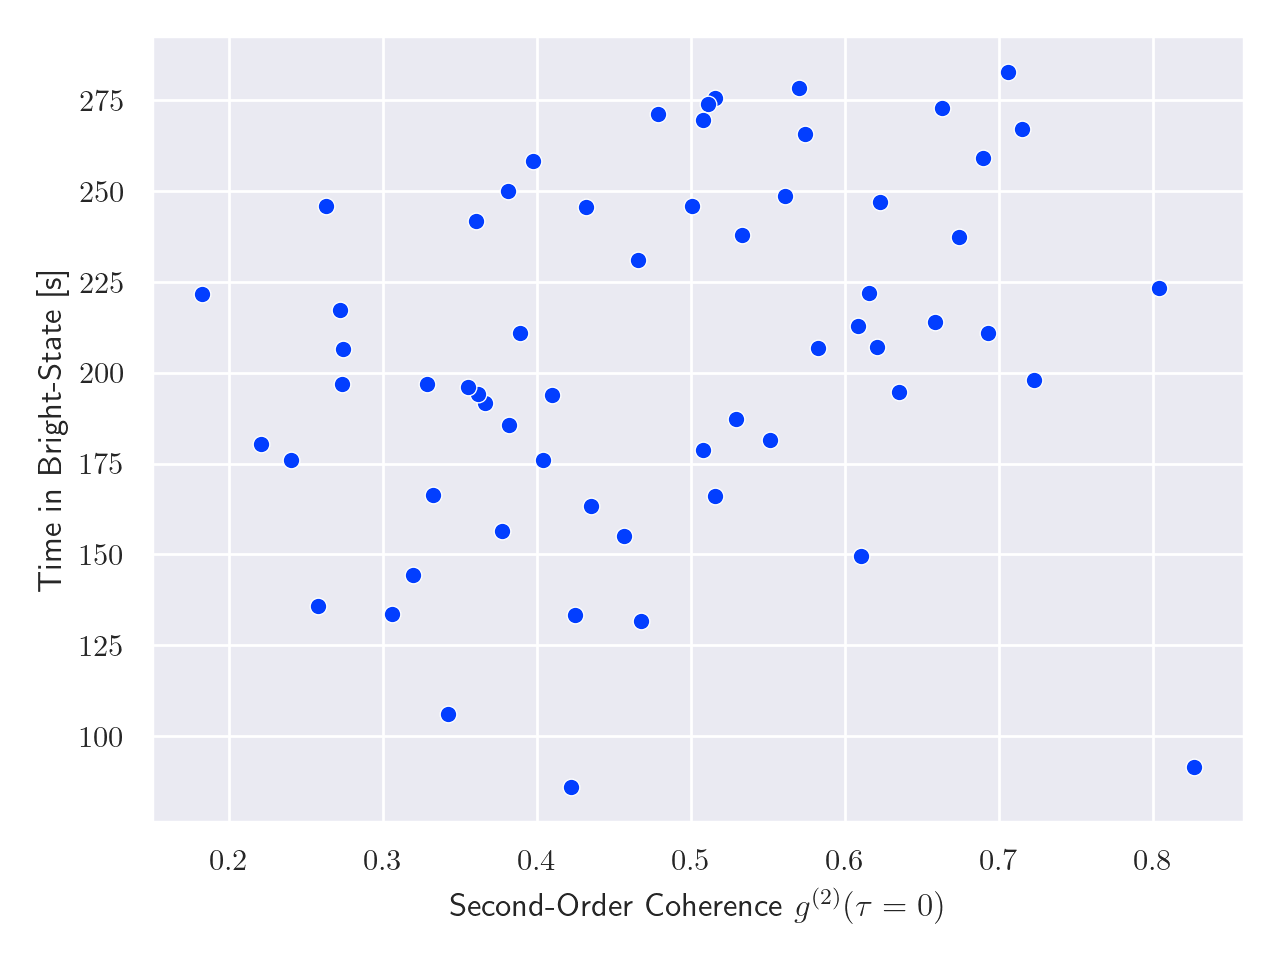

In [7]:
fig = plt.figure()
sns.set_palette("bright")
sns.scatterplot(data=df, x="g2_tau_zero", y="time_above_threshold")

plt.xlabel(r"Second-Order Coherence $g^{(2)}(\tau = 0)$")
plt.ylabel(r"Time in Bright-State [s]")

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


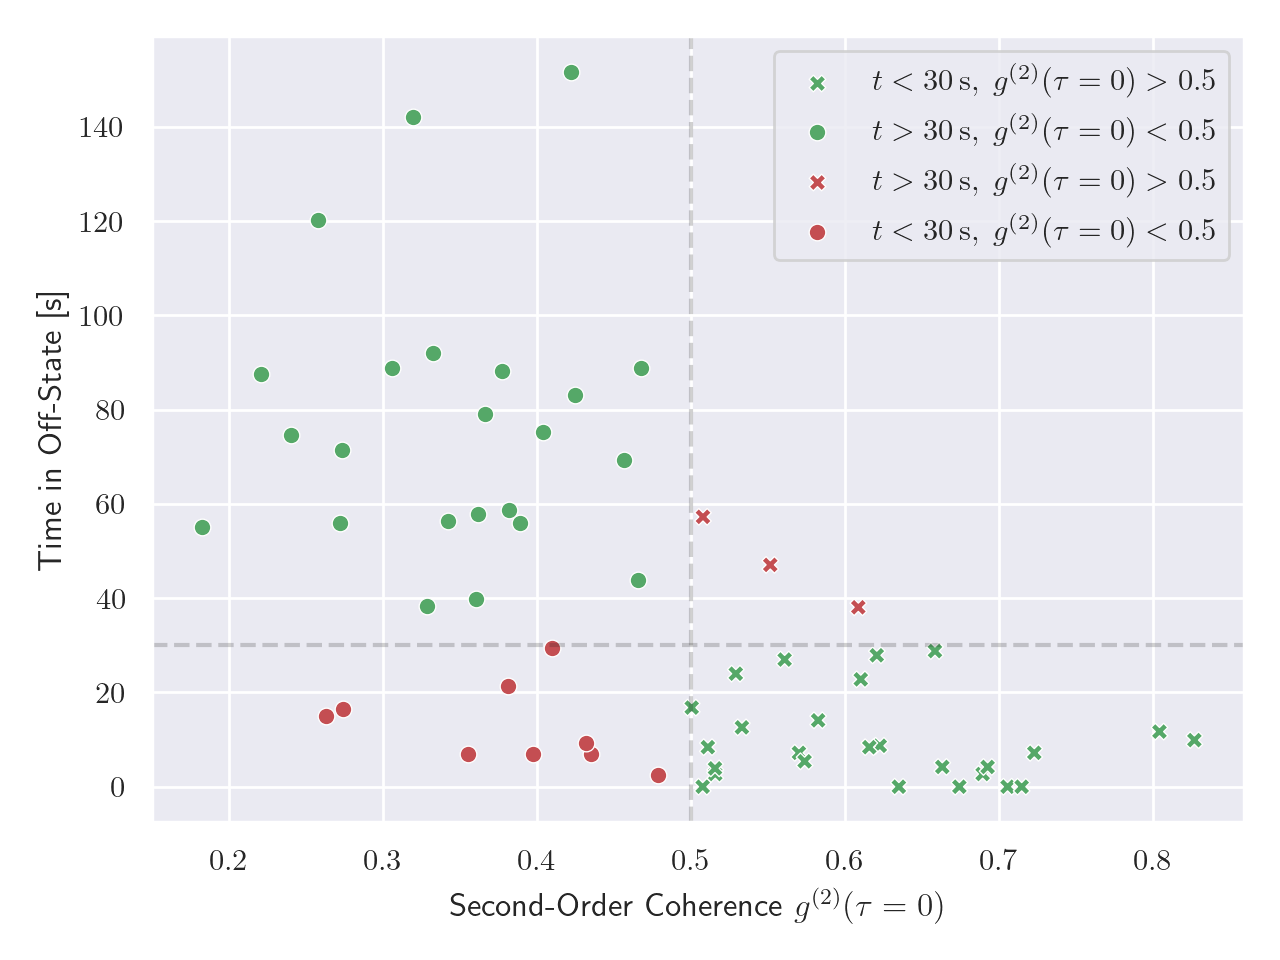

In [8]:
fig = plt.figure()
sns.set_palette("bright")
#sns.scatterplot(data=df, x="g2_tau_zero", y="time_below_threshold_100")
#sns.scatterplot(data=df[df["time_below_threshold_100"]>30], x="g2_tau_zero", y="time_below_threshold_100", label = r"$t > 30\,\mathrm{s}$")

sns.scatterplot(data=df[(df["g2_tau_zero"] > 0.5) & (df["time_below_threshold_100"] < 30)], x="g2_tau_zero", y="time_below_threshold_100", color="g", label = r"$t < 30\,\mathrm{s},\; g^{(2)}(\tau = 0) > 0.5$",style=True, markers=['X'], legend=False)
sns.scatterplot(data=df[(df["g2_tau_zero"] < 0.5) & (df["time_below_threshold_100"] > 30)], x="g2_tau_zero", y="time_below_threshold_100", color="g", label = r"$t > 30\,\mathrm{s},\; g^{(2)}(\tau = 0) < 0.5$")
sns.scatterplot(data=df[(df["g2_tau_zero"] > 0.5) & (df["time_below_threshold_100"] > 30)], x="g2_tau_zero", y="time_below_threshold_100", color="r", label = r"$t > 30\,\mathrm{s},\; g^{(2)}(\tau = 0) > 0.5$",style=True, markers=['X'], legend=False)
sns.scatterplot(data=df[(df["g2_tau_zero"] < 0.5) & (df["time_below_threshold_100"] < 30)], x="g2_tau_zero", y="time_below_threshold_100", color="r", label = r"$t < 30\,\mathrm{s},\; g^{(2)}(\tau = 0) < 0.5$")

plt.axhline(y=30, color="k", linestyle="--", alpha=0.2)
plt.axvline(x=0.5, color="k", linestyle="--", alpha=0.2)

plt.xlabel(r"Second-Order Coherence $g^{(2)}(\tau = 0)$")
plt.ylabel(r"Time in Off-State [s]")
#plt.title("22-11-17_AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_Lorentzian_fit_coeffs_local")

fig.tight_layout()
plt.show()
fig.savefig("Data/g2_vs_t_below_threshold_v4_1.pdf")
fig.savefig("Data/g2_vs_t_below_threshold_v4_1.png", dpi=600,transparent=False)

<IPython.core.display.Javascript object>


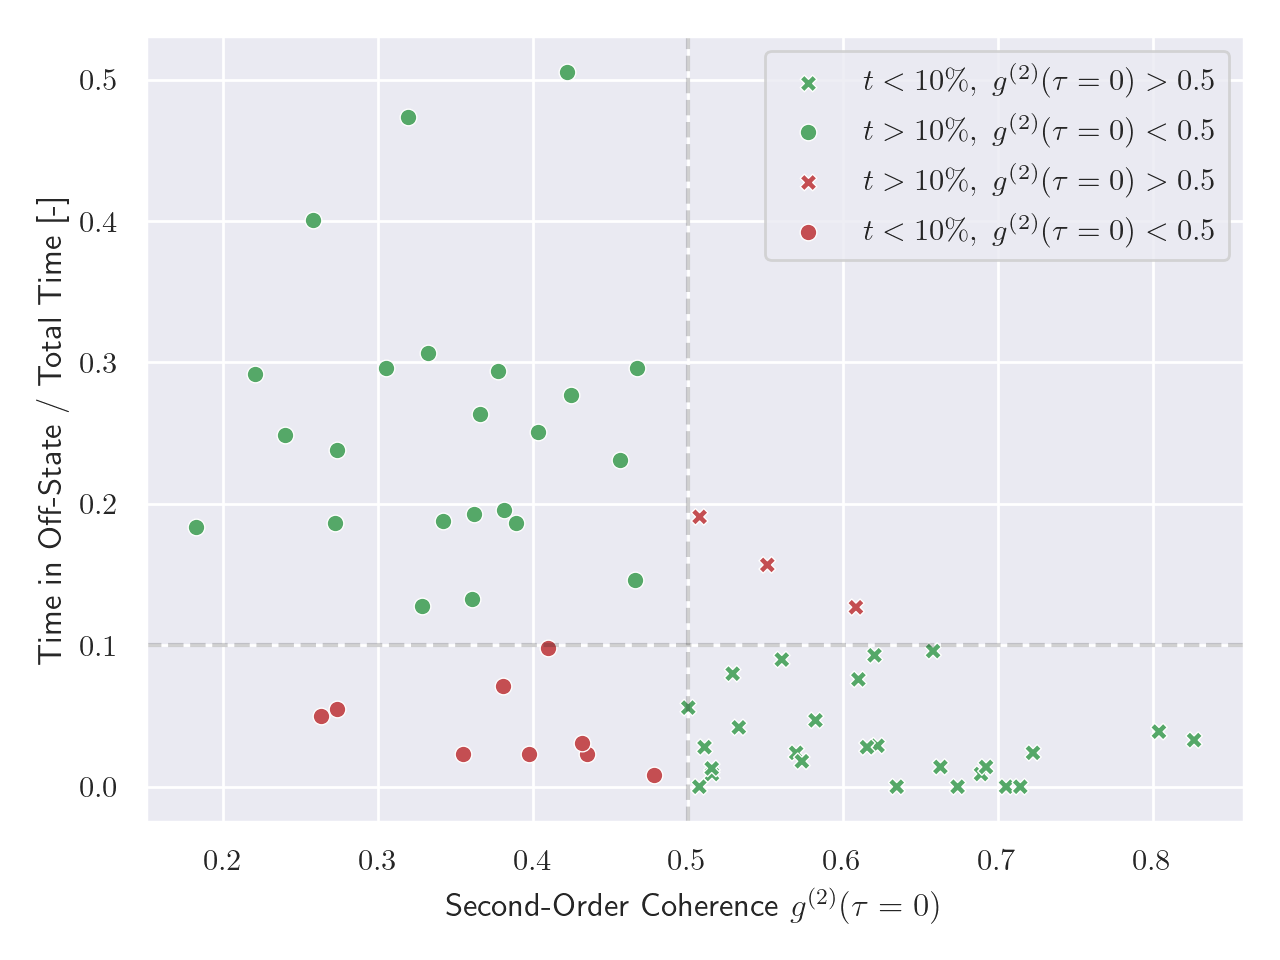

In [9]:
fig = plt.figure()
sns.set_palette("bright")
#sns.scatterplot(data=df, x="g2_tau_zero", y="percent_below_threshold_100")

sns.scatterplot(data=df[(df["g2_tau_zero"] > 0.5) & (df["percent_below_threshold_100"] < 0.1)], x="g2_tau_zero", y="percent_below_threshold_100", color="g", label = r"$t < 10\%,\; g^{(2)}(\tau = 0) > 0.5$",style=True, markers=['X'], legend=False)
sns.scatterplot(data=df[(df["g2_tau_zero"] < 0.5) & (df["percent_below_threshold_100"] > 0.1)], x="g2_tau_zero", y="percent_below_threshold_100", color="g", label = r"$t > 10\%,\; g^{(2)}(\tau = 0) < 0.5$")
sns.scatterplot(data=df[(df["g2_tau_zero"] > 0.5) & (df["percent_below_threshold_100"] > 0.1)], x="g2_tau_zero", y="percent_below_threshold_100", color="r", label = r"$t > 10\%,\; g^{(2)}(\tau = 0) > 0.5$",style=True, markers=['X'], legend=False)
sns.scatterplot(data=df[(df["g2_tau_zero"] < 0.5) & (df["percent_below_threshold_100"] < 0.1)], x="g2_tau_zero", y="percent_below_threshold_100", color="r", label = r"$t < 10\%,\; g^{(2)}(\tau = 0) < 0.5$")

plt.axhline(y=0.1, color="k", linestyle="--", alpha=0.2)
plt.axvline(x=0.5, color="k", linestyle="--", alpha=0.2)

plt.xlabel(r"Second-Order Coherence $g^{(2)}(\tau = 0)$")
plt.ylabel(r"Time in Off-State / Total Time [-]")
#plt.title("22-11-17_AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_Lorentzian_fit_coeffs_local")

fig.tight_layout()
plt.show()
fig.savefig("Data/g2_vs_t_below_threshold_percentage_4.pdf")
fig.savefig("Data/g2_vs_t_below_threshold_percentage_4.png", dpi=600,transparent=False)

In [10]:
print(np.size((df[(df["g2_tau_zero"] < 0.5) & (df["time_below_threshold_100"] > 30)]).iloc[:,0]))
print(np.size((df[(df["g2_tau_zero"] < 0.5) & (df["time_below_threshold_100"] < 30)]).iloc[:,0]))
print(np.size((df[(df["g2_tau_zero"] > 0.5) & (df["time_below_threshold_100"] > 30)]).iloc[:,0]))
print(np.size((df[(df["g2_tau_zero"] > 0.5) & (df["time_below_threshold_100"] < 30)]).iloc[:,0]))

23
9
3
26


# Chi vs g2(tau = 0)

In [11]:
df = pd.read_csv("Data/AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_250nW_ptu_x_77_y93_z124_range30_pts150Lorentzian_fit_coeffs_local.csv")
#df.dropna()
df[df["chisqr_normed"] < 0.14]

,Unnamed: 0,a,mean,sigma,redchi,chisqr,fwhm,a_normed,mean_normed,sigma_normed,fwhm_normed,height_normed,redchi_normed,chisqr_normed,state_g2,g2_tau_zero,included,filename
5,6,1370.691246,3.926999,0.126360,3898.266725,8.654152e+05,0.252719,0.000484,2.173643,0.000827,0.001655,0.186144,0.000004,0.000954,discarded,NaN,False,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
8,9,1458.808634,2.282860,0.034766,586470.666236,1.301965e+08,0.069531,0.124278,2.284249,0.041286,0.082572,0.958165,0.000262,0.058223,singular,0.319243,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
9,11,624.598544,2.278022,0.036435,124780.771261,2.770133e+07,0.072870,0.130267,2.279886,0.042870,0.085741,0.967225,0.000622,0.138144,discarded,NaN,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
13,17,1286.630449,2.307205,0.033866,475127.240200,1.054782e+08,0.067731,0.122436,2.308420,0.040728,0.081457,0.956887,0.000414,0.091830,singular,0.273604,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
15,19,646.600254,2.306084,0.041528,84890.842541,1.884577e+07,0.083055,0.146655,2.306628,0.048260,0.096521,0.967289,0.000584,0.129612,singular,0.328529,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
16,20,689.305841,2.268119,0.033970,136353.494099,3.027048e+07,0.067941,0.118382,2.269866,0.038626,0.077253,0.975557,0.000561,0.124465,non_singular,0.456001,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
19,23,831.809764,2.323922,0.037414,172782.618964,3.835774e+07,0.074828,0.131613,2.325512,0.043222,0.086443,0.969278,0.000512,0.113561,non_singular,0.515362,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
21,25,962.773176,2.298435,0.039007,195834.847696,4.347534e+07,0.078014,0.136488,2.299448,0.044903,0.089806,0.967534,0.000415,0.092148,non_singular,0.434894,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."
23,27,586.876216,2.288301,0.032238,115575.648879,2.565779e+07,0.064476,0.115637,2.290137,0.038064,0.076128,0.967013,0.000564,0.125206,singular,0.381494,True,"AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_405exct_..."


<IPython.core.display.Javascript object>


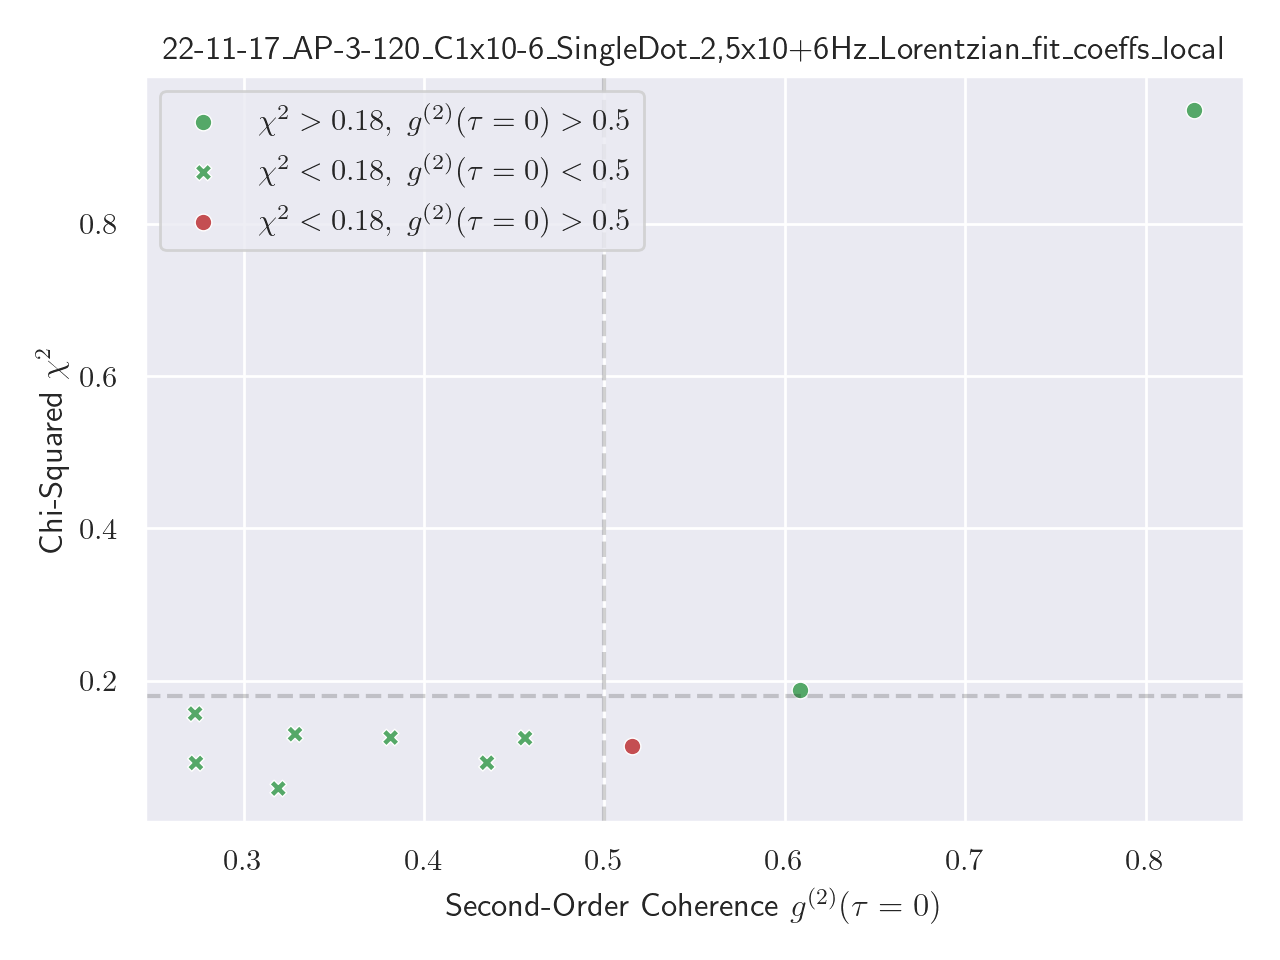

In [12]:
fig = plt.figure()
sns.set_palette("bright")
#sns.scatterplot(data=df, x="g2_tau_zero", y="chisqr_normed")
#sns.scatterplot(data=df[df["chisqr_normed"]<0.18], x="g2_tau_zero", y="chisqr_normed", label = r"$\chi^2<0.18$", color="r")

#sns.scatterplot(data=df[df["chisqr_normed"]<0.18], x="g2_tau_zero", y="chisqr_normed", label = r"$\chi^2<0.18$", color="b")
sns.scatterplot(data=df[(df["chisqr_normed"] >= 0.18) & (df["g2_tau_zero"] > 0.5)], x="g2_tau_zero", y="chisqr_normed", color="g", label = r"$\chi^2 > 0.18,\; g^{(2)}(\tau = 0) > 0.5$")
sns.scatterplot(data=df[(df["chisqr_normed"] < 0.18) & (df["g2_tau_zero"] < 0.5)], x="g2_tau_zero", y="chisqr_normed", color="g", label = r"$\chi^2 < 0.18,\; g^{(2)}(\tau = 0) < 0.5$",style=True, markers=['X'], legend=False)
sns.scatterplot(data=df[(df["chisqr_normed"] < 0.18) & (df["g2_tau_zero"] > 0.5)], x="g2_tau_zero", y="chisqr_normed", color="r", label = r"$\chi^2 < 0.18,\; g^{(2)}(\tau = 0) > 0.5$")

plt.axhline(y=0.18, color="k", linestyle="--", alpha=0.2)
plt.axvline(x=0.5, color="k", linestyle="--", alpha=0.2)


plt.xlabel(r"Second-Order Coherence $g^{(2)}(\tau = 0)$")
plt.ylabel(r"Chi-Squared $\chi^2$")
plt.title("22-11-17_AP-3-120_C1x10-6_SingleDot_2,5x10+6Hz_Lorentzian_fit_coeffs_local")

plt.legend(loc=2)
fig.tight_layout()
plt.show()
fig.savefig("Data/g2_vs_chisqr_normed_v3.pdf")

# Piechart

<IPython.core.display.Javascript object>


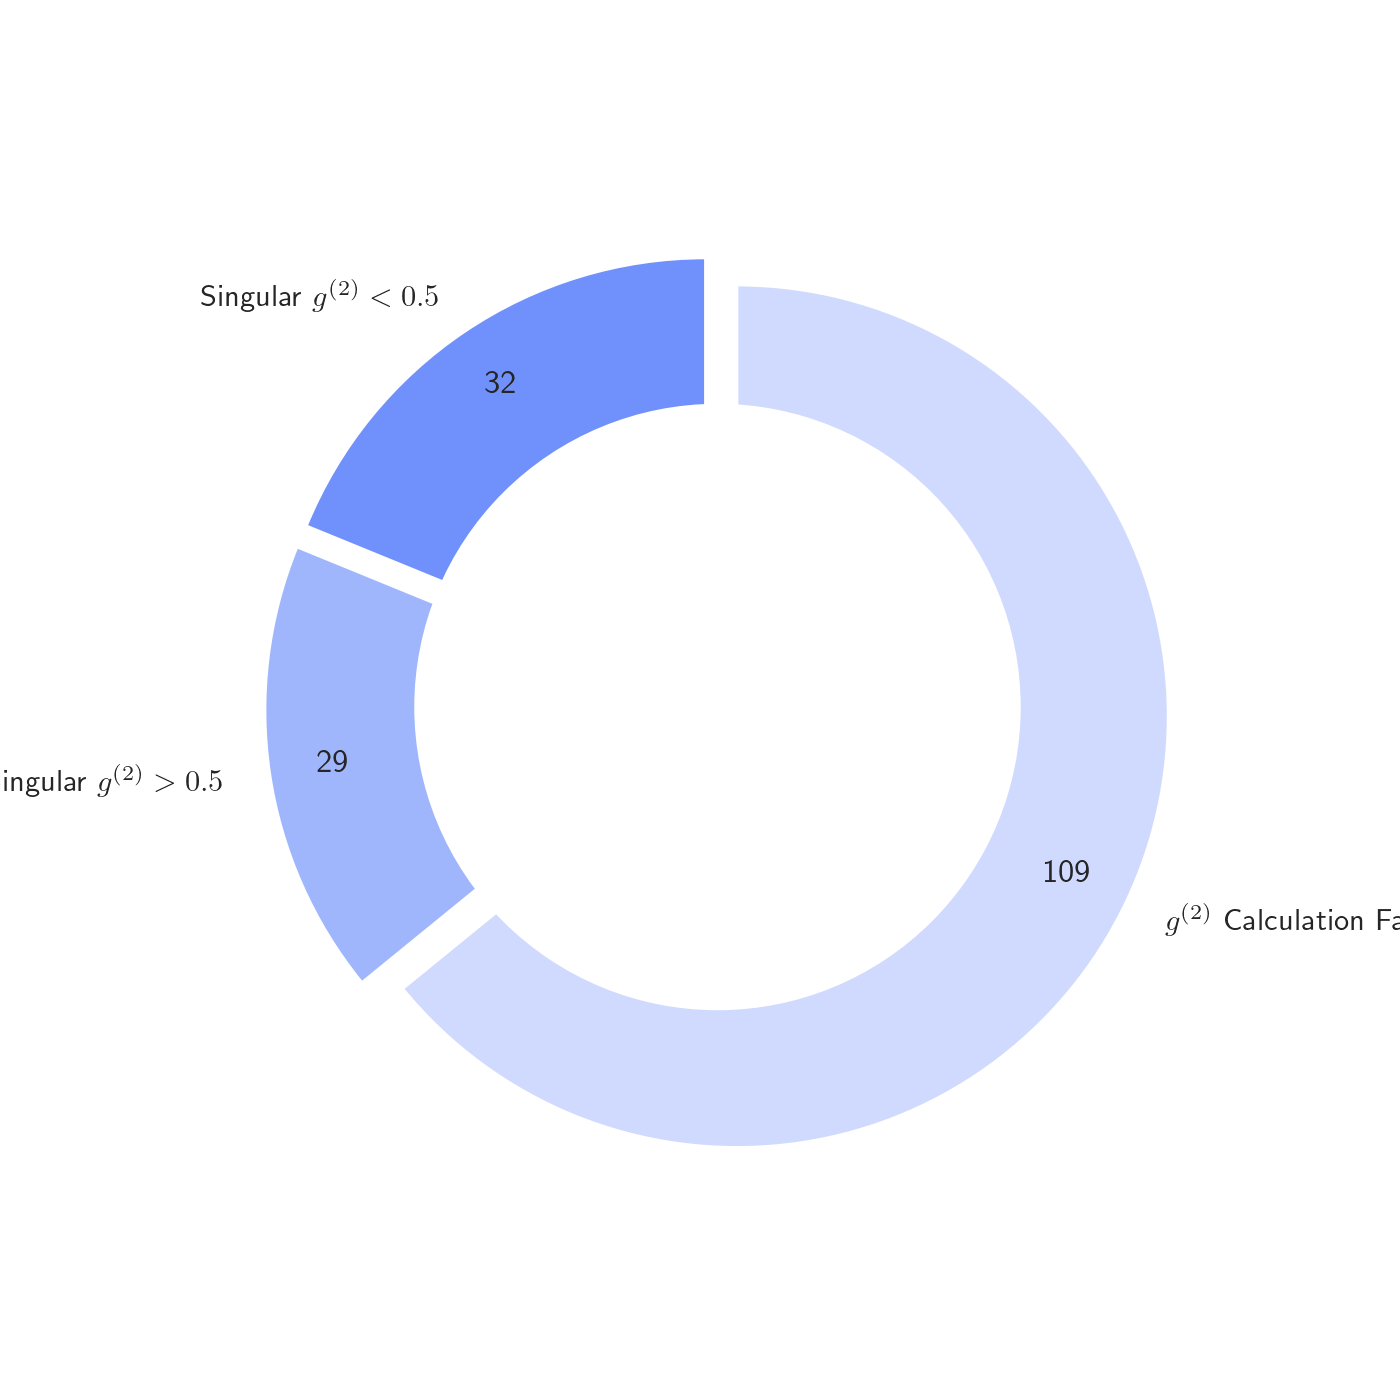

NameError: name 'ax1' is not defined

In [13]:
# Pie chart
labels = [r'Singular $g^{(2)}<0.5$', r'Non-Singular $g^{(2)}>0.5$', '$g^{(2)}$ Calculation Failed']
sizes = [32, 29, 109]
colors = ['#7091FC', '#9FB6FD', '#CFDAFE']
explode = (0.05,0.05,0.05)
total = sum(sizes)

fig = plt.figure(figsize=(7,7))
plt.pie(sizes, colors = colors, labels=labels, autopct=lambda p: '{:.0f}'.format(p * total / 100), startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

fig.tight_layout(pad=1)
plt.show()
fig.savefig("Data/pie_chart.pdf")
fig.savefig("Data/pie_chart.png", dpi=600, transparent=True)